In [4]:
import pandas as pd



n=pd.read_csv("..\data\hywind_generation.csv")

In [5]:
n.head()
n.tail()

,datetime,power,cf_trace
11093,2020-03-31 17:00:00,20.72,0.873156
11094,2020-03-31 18:00:00,21.10,0.889170
11095,2020-03-31 19:00:00,17.09,0.720185
11096,2020-03-31 20:00:00,14.21,0.598820
11097,2020-03-31 21:00:00,16.55,0.699789


In [6]:
#standard first-try-code from cds-webpage
#import cdsapi
#cds = cdsapi.Client()
#cds.retrieve('reanalysis-era5-pressure-levels', {
#           "variable": "temperature",
#           "pressure_level": "1000",
#           "product_type": "reanalysis",
#           "date": "2017-12-01/2017-12-31",
#           "time": "12:00",
#           "format": "grib"
#       }, 'download.grib')

## Aus dem Tutorial

In [8]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

In [9]:
#zunächst kam ein Fehler: pyproj not found? beim zweiten Druchlauf geht's

In [10]:
cutout = atlite.Cutout(path="north-sea-region-111.nc",
                       module="era5",
                       x=slice(-4.2600, 10.0000),
                       y=slice(51.4000, 60.8479),# vermutlich erste Stelle immer der kleinere Wert
                       time=slice("2017-11-01","2017-11-30")
                       )
#statt x,y könnte man den Rand eines selbsterstellten shapefile übergeben

In [11]:
#cutout = atlite.Cutout(path="western-europe-2017-xxx.nc",
#                       module="era5",
#                       x=slice(-13.6913, 1.7712),
#                       y=slice(49.9096, 60.8479),
#                       time="2011-01"#slice("2017-11-01","2017-01-01")
#                       )

In [12]:
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "north-sea-region-111">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2017-11-01 ⟷ 2017-11-30, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [13]:
cutout.data

<xarray.Dataset>
Dimensions:           (x: 58, y: 38, time: 720)
Coordinates:
  * x                 (x) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0
  * y                 (y) float64 51.5 51.75 52.0 52.25 ... 60.25 60.5 60.75
  * time              (time) datetime64[ns] 2017-11-01 ... 2017-11-30T23:00:00
    lon               (x) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(38,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(38, 58), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'influx', 'runoff', 'temperature', 'wind']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2022-11-02 14:59:36 GMT by grib_to_netcdf-2.25.1: /op...

In [14]:
cutout.path

WindowsPath('north-sea-region-111.nc')

In [15]:
cutout.wind

<bound method wind of <Cutout "north-sea-region-111">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2017-11-01 ⟷ 2017-11-30, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

In [16]:
cutout.prepared_features

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

In [17]:
#später wird hier die Intermediate matrix genutzt, also kein "georgrapisches shapefile"

#dieses Beispiel gehört zu create cutpout in der ATLITE DOkumentation
#und der Cutout für PV in Deutschland,
#TODO: später angucken

#import cartopy.io.shapereader as shpreader
#import geopandas as gpd
#shp = shpreader.Reader(shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries'))
#de_record = list(filter(lambda c: c.attributes['ISO_A2'] == 'DE', shp.records()))[0]
#de = pd.Series({**de_record.attributes, 'geometry':de_record.geometry})
#x1, y1, x2, y2 = de['geometry'].bounds

In [18]:
from shapely.geometry import Polygon
import geopandas

#crs ist immer die Auswahl der Projektion

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
#hiermit werden die Länder mit Grenzen von den erwähnten Nationendargestellt
BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) #hier gibt man die Länderbezeichnungen ein
##epsg:4326 ist die ganze Welt als Koordiantenebene, wird zusammen mit UTM 32 genutzt (Lagebezugssystem), EPSG 4326 ist der Code für dit WGS84-Projektion


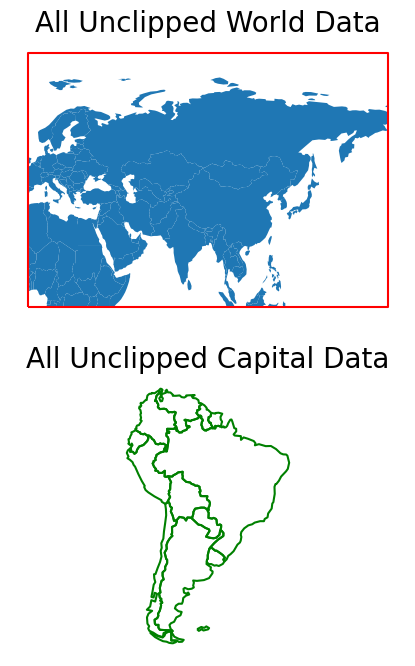

In [19]:
#naturalearth: Standard-Ansicht der Welt:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#Teilmenge: nur die Länder dargestellt, die als Attribut "South America" haben
#south_america = world[world["continent"] == "South America"]

# naturalearth+cx
#in dieser Variante werden die Länder komplett dargestellt, auch wenn nur ein minimales Stück im definierten cx-Bereich liegt = Länge und Breit
#BorderingStates =gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).cx[-15:10, 52:55]
#BorderingStates.plot(figsize=(10, 10))

#Clipping example modified to exclude world outside of Polygon
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
south_america = world[world["continent"] == "South America"]
#beliebiges Polygon einfügen:
#erst Polygon-Objekt definieren, dieses dann einen GDF übergeben
polygon = Polygon([(0, 0), (0, 90), (180, 90), (180, 0), (0, 0)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
#south_america.plot(figsize=(10,10))
world= world.clip(poly_gdf) # world minus everything outside of polygon

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
world.plot(ax=ax1)
poly_gdf.boundary.plot(ax=ax1, color="red")
south_america.boundary.plot(ax=ax2, color="green")
#capitals.plot(ax=ax2, color="purple")
ax1.set_title("All Unclipped World Data", fontsize=20)
ax2.set_title("All Unclipped Capital Data", fontsize=20)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()


In [20]:
#select a subset from the gpdf: every entry with the attribute asia i the column "continent"
world_asia=world[world["continent"] =='Asia']


In [21]:
projection = ccrs.Orthographic(-10, 35)

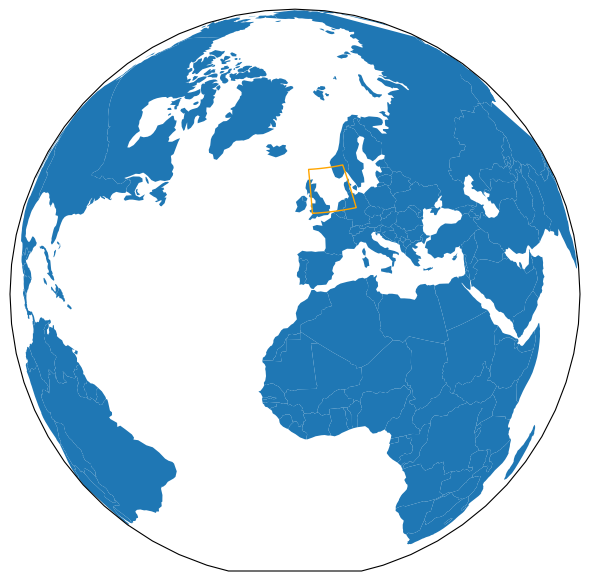

In [22]:
#hier wird der Cutout-Bereich verwendet, ich hatte ihn adaptiert an NSR
#hier wird Ländershape noch nicht verwendet
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(-10,35) #beide Paramter sind die Mittelpunkt der Porjektion, central lon und central lat
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
fig.tight_layout()



**Plotting the cutout with abstract land borders**

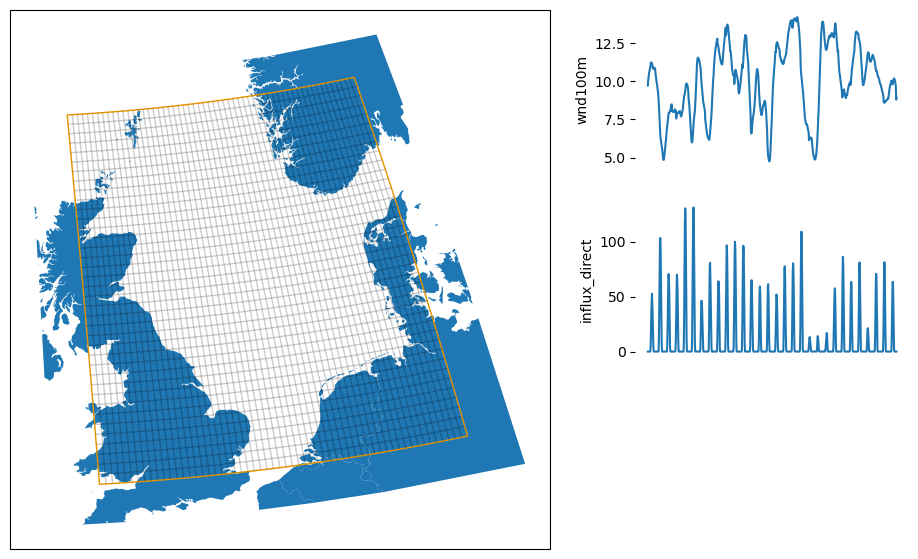

In [23]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig) #sorgt für mehrere Diagramme in einem Plot

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

# als Referenz nochmal das gelbe Grid
#x=slice(-4.2600, 10.0000),
#y=slice(51.4000, 60.8479)

# übersichtliche Darstellung des Polygons
#beschreibt eine Linie von mehreren Punkten, alternativ : polygon2 = Polygon([90,0], usw.)
lat_point_list = [50.4,61.8479, 61.8479, 50.4,50.4]
lon_point_list = [-6.26, -6.26 , 12 ,12, -6.26 ]
#man muss ganz oben Border_init nochmal laufen lassen, ansonsten wird die Variable gelegentlich "vergessen"
# so ganz versteh ich nicht, warum ein falscher Polygonzuschnitt bei mehreren Durchläufen im internen Speicher des .ipynb beibehalten wird
#oben shpreader nochmal laufenm bevor Änderungen wirksam werden
polygon2 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf2 = gpd.GeoDataFrame([1], geometry=[polygon2], crs=world.crs)
#eigentlicher Clip-Befehl, kürzt oben genannte Staatengruppe auf den Auswahlbereich ein
BorderingStates_init= BorderingStates_init.clip(poly_gdf2)

BorderingStates_init.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
#hier wird das Raster gelayoutet,country_bound als Name ist Überbleibsel vom Tutorial
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())

ax.outline_patch.set_edgecolor('black')

#Zugriff auf die Wetterdaten des Cutouts
#über alle Datenpunkte wird pro Merkmal das Mittel gebildet
ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

#Influx ist der Zustrom von Feuchtigkeit, relevant?
ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

#runoff ist Oberflächenwasser, unwichtig
#ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
#cutout.data.runoff.mean(['x', 'y']).plot(ax=ax3)
#ax3.set_frame_on(False)
#ax3.set_xlabel(None)
#fig.tight_layout()
#


**Plotting the windfarms from EMODNet with a map from OpenStreetMap**

Text(0.5, 1.0, 'first_try')

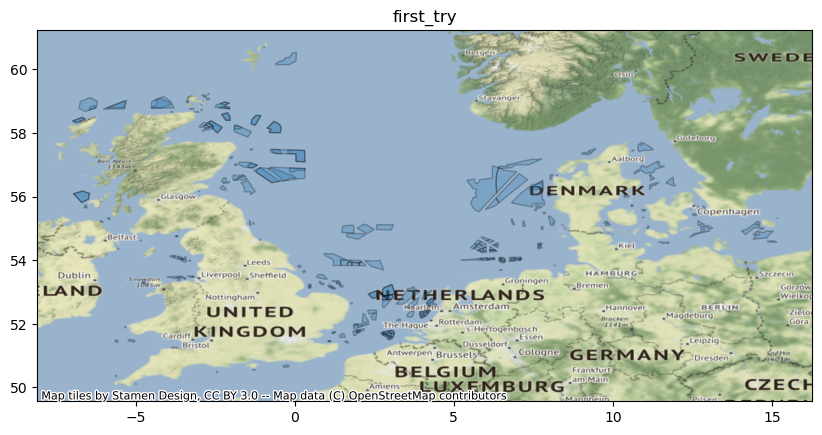

In [24]:
import contextily as cx

#beispiel für runterladen von Online-Karten per Namen
#import rasterio
#bristol = cx.Place("Rostock", path="bristol.tif")
#from rasterio.plot import show as rioshow
#with rasterio.open("bristol.tif") as r:
#    rioshow(r)

#erstes grundlegendes Beispiel für eine Tile-Map und Potten von Punkten
#data_url = "https://ndownloader.figshare.com/files/20232174"
#db = geopandas.read_file(data_url)
#
#db.plot()
#ax = db.plot(color="red", figsize=(9, 9))
#cx.add_basemap(ax, crs=db.crs.to_string()) #crs ist nötig, sonst anderer Zoom der Punkte und verschoben


#Karte von oben
# das funktioniert, hier kriegt die Basemap dasCRS der Windfarms, merkwürdigerweise funktioniert ers andersherum nicht (s.u.)
#außerdem Verzeicht auf fig,ax =subplots....
windfarm_map = gpd.read_file("../data/Windpark-Shapefiles GB/EMODnet_HA_WindFarms_pg_20220324.shp")
#windfarm_map=windfarm_map[windfarm_map["COUNTRY"] =="Spain"] #Dataframe auswahl eines Subsets

#TODO: wünschenswert wäre eine Selection basierend auf den koordinaten
#DONE siehe nächste Zelle: Methode overlay
windfarm_map=windfarm_map[windfarm_map["COUNTRY"].isin(['United Kingdom','Denmark','Belgium','Norway','Germany','Netherlands'
])] #Auswahl mehrerer Zeilen sowie oder-Bedingung

#contextily chooses the right zoom factor automatically
ax = windfarm_map.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map.crs) # der passende Ausschnitt wird zugewiesen
#ax.axis("off")
ax.set_title("first_try")

#merkwürdigerweise funktioniert die Standard-variante nicht
#windfarm_map.to_crs(epsg=3857)
#fig, ax = plt.subplots (figsize = (15,15))
#windfarm_map.plot(ax=ax)
#cx.add_basemap(ax=ax,crs= 3857)
#cx.add_basemap(ax)


#Beispiel für runtergeladene Dateien
#https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png'

# in den Beispiel wird es erst die zu plottende shp erst unter ax gespeichert?, dann cx.add_basemapp (ax =ax)?
#df = gpd.read_file('linz/StatBez_Linz_EPSG_4326.gml')
#df = df.to_crs(epsg=3857)
#
#fig = plt.figure(figsize=(16,9))
#ax = plt.subplot()
#ctx.add_basemap(ax = ax, source=ctx.providers.Stamen.Toner, crs=df.crs.to_string())
#df.plot(color='none',edgecolor='green', ax = ax)

#ax = fig.add_subplot(projection=projection)
#plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
#                      facecolor='None', transform=plate())
#
#BorderingStates_init= BorderingStates_init.clip(poly_gdf2)
#
#BorderingStates_init.plot(ax=ax, zorder=1, transform=plate())
#cells.plot(ax=ax, **plot_grid_dict)
#country_bound.plot(ax=ax, edgecolor='orange',
#                   facecolor='None', transform=plate())
#
#ax.outline_patch.set_edgecolor('black')








#fig = plt.figure(figsize=(12, 10))
#ax3 = fig.add_subplot(gs[:, 0:2], projection=projection)


**Plot all windfarms, that are located in the cutout**

Text(0.5, 1.0, 'second_try')

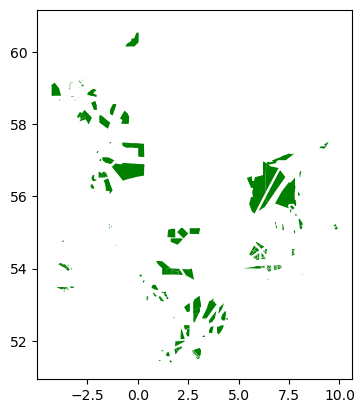

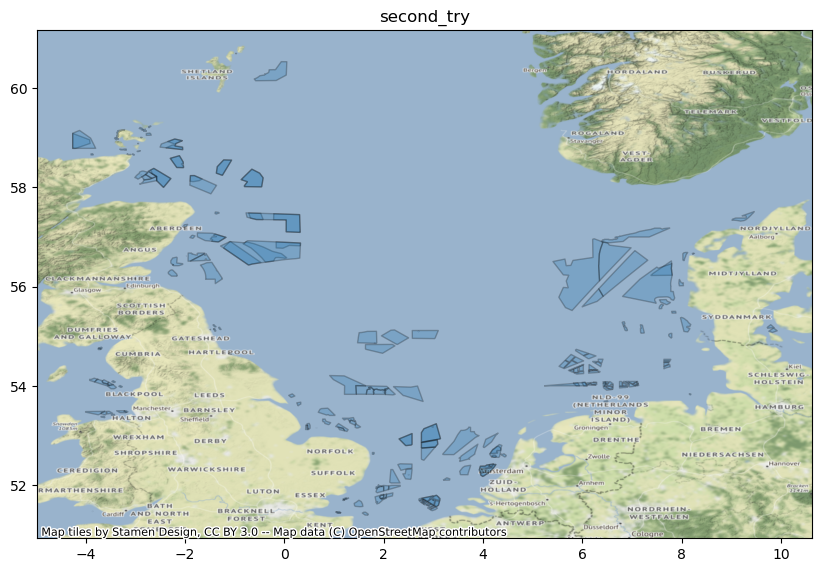

In [25]:
windfarm_map.columns
windfarm_map.head()


#take the polygon from cds-input: = -4.25 ⟷ 10.00, dx = 0.25
 #y = 51.50 ⟷ 60.75, dy = 0.25

lat_point_list = [51.4,60.8479, 60.8479,51.4,51.4]
lon_point_list = [-4.26, -4.26 , 10 ,10, -4.26 ]
polygon3 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf3 = gpd.GeoDataFrame([1], geometry=[polygon3], crs=windfarm_map.crs)

fig, (ax) = plt.subplots()
#poly_gdf3.plot(ax=ax,color='red', edgecolor='grey')
#windfarm_map.plot(ax=ax)

#windfarm_map.reset_index(drop=False, inplace=True)
windfarm_map_reduced = gpd.overlay(windfarm_map,poly_gdf3, how='intersection')
#that function also eliminates polygons outside of the scope of polygon 3
#TODO: remove windparks east of Denamark and west of Grea Britain based on Lat and Longitude
#DONE: see below


#reindex took place automatically during overlay-method, else: df.reset_index()

windfarm_map_reduced.plot(ax=ax,color='green')

#contextily plotting of windfarms on topographic map
ax = windfarm_map_reduced.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map_reduced.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("second_try")
#
#display(windfarm_map_reduced)

**Discard windfarms, that are not located in the North Sea**

(224, 14)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea')

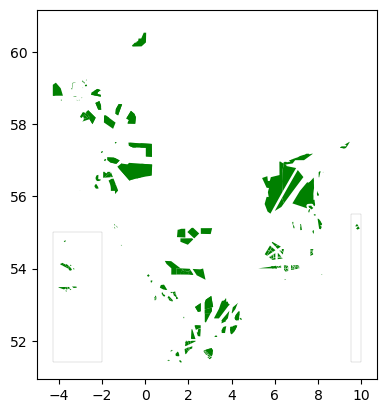

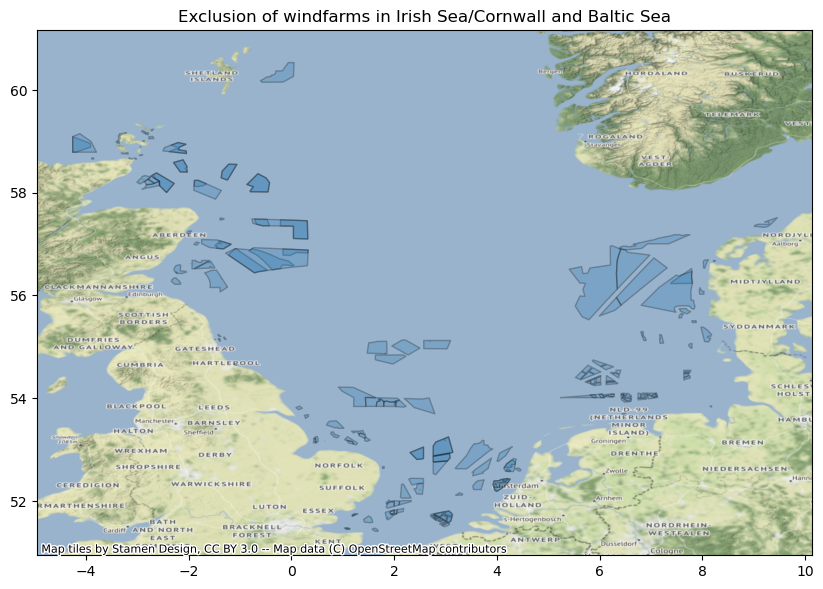

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', 1000)
#pd.options.display.width = 0
pd.set_option('display.max_colwidth',150)
#pd.set_option('display.width', 1000)
windfarm_map_reduced.shape

#windfarm_map_reduced.iloc[4,5]
#windfarm_map_reduced.columns
#windfarm_map_reduced.loc[4,'NAME']

#conditions
#test= windfarm_map_reduced[windfarm_map_reduced.YEAR > 2017]

#windfarm_map_reduced.loc[windfarm_map_reduced.YEAR > 2017]
#windfarm_map_reduced
#windfarm_map_reduced.loc[1,['STATUS','COUNTRY']]

# kleiner als im Datafragme + drop #
#windfarm_map_reduced.loc[8:10,'geometry']
#list(windfarm_map_reduced["geometry"][8].exterior.coords)


#verwerfe bestimmte Koordinaten
#within/cintains polygon#
lat_point_list = [51.4,55.0, 55.0,51.4,51.4]
lon_point_list = [-4.26, -4.26 , -2 ,-2, -4.26 ]
polygon4 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_west = gpd.GeoDataFrame([1], geometry=[polygon4], crs=windfarm_map_reduced.crs)

lat_point_list = [51.4,55.5, 55.5,51.4,51.4]
lon_point_list = [9.5, 9.5 , 10 ,10, 9.5 ]
polygon5 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_east = gpd.GeoDataFrame([1], geometry=[polygon5], crs=windfarm_map_reduced.crs)

#within verlangt eine Series auf der Linken Seite: sie sucht sie sich im GPDF eigenständig, aber die einzelne Form muss eine Shapely-Objekt sein = Polygon
bool1= windfarm_map_reduced.within(polygon4) #ergibt eine Boolean-Tabelle
bool2= windfarm_map_reduced.within(polygon5)
#drop geht nur, wenn beide denselben Index haben , ist hier der Fall, ansonsten filter man mittels einer Serie, wie hier
bool3= bool1 + bool2

#windfarm_map_reduced
#bool2
windfarm_new= windfarm_map_reduced[~bool3.values]


#windfarm_map_reduced = windfarm_map_reduced[windfarm_map_reduced.within(polygon3) ==False]

#windfarm_map_reduced.loc[:,'geometry'] #type: GeoSeries
#windfarm_map_reduced['geometry'])  #type: GeoSeries
#windfarm_map_reduced.iloc[46:48,:]
#windfarm_map_reduced['geometry'][45#:49]

fig,ax1 =plt.subplots()

windfarm_map_reduced.plot(ax=ax1,color='green')
poly_gdf_excl_east.plot(ax=ax1,color='none',edgecolor='black',linewidth=0.08)
poly_gdf_excl_west.plot(ax=ax1,color='none',edgecolor='black',linewidth=0.08)

#contextily plotting of windfarms on topographic map
ax = windfarm_new.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_new.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea")
#




In [30]:

windfarm_new.reset_index(drop=True, inplace=True)
windfarm_new.shape
windfarm_new


(204, 14)

,OBJECTID,COUNTRY,NAME,N_TURBINES,POWER_MW,STATUS,YEAR,COAST_DIST,AREA_SQKM,NOTES,Shape_Leng,Shape_Area,0,geometry
0,8,Belgium,Rentel,42,309.00,Production,2018,28354.728982,23.264154,None,0.260649,0.003017,1,"POLYGON ((2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51.58800, 2.98329 51..."
1,9,Belgium,Norther,44,370.00,Production,2018,19797.758680,38.445331,None,0.352805,0.004979,1,"POLYGON ((2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51.53645, 2.99906 51..."
2,10,Belgium,Seastar,30,252.00,Production,2020,36085.954019,18.426179,None,0.222749,0.002392,1,"POLYGON ((2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51.65772, 2.87846 51..."
3,11,Belgium,Mermaid,28,235.20,Production,2020,48314.549431,16.676150,None,0.208196,0.002169,1,"POLYGON ((2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51.71045, 2.71777 51..."
4,12,Belgium,C-Power (Zone A),24,141.15,Production,2013,24793.536916,10.682070,None,0.174694,0.001384,1,"POLYGON ((2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680, 2.90836 51.55810))"
5,13,Belgium,C-Power (Zone B),30,184.50,Production,2013,25036.117115,9.169407,None,0.167815,0.001188,1,"POLYGON ((3.01127 51.57743, 3.00446 51.57128, 3.01785 51.56379, 3.00503 51.55993, 2.99597 51.55509, 2.98756 51.54976, 2.97854 51.54401, 2.95222 51..."
6,14,Belgium,Northwind,72,216.00,Production,2014,33657.535000,8.741283,None,0.195543,0.001134,1,"POLYGON ((2.86010 51.60298, 2.89200 51.61585, 2.88862 51.61788, 2.90553 51.62469, 2.91273 51.62830, 2.92687 51.63656, 2.94461 51.62589, 2.93036 51..."
7,15,Belgium,Belwind phase 1,55,165.00,Production,2010,40610.684576,14.740648,None,0.208410,0.001915,1,"POLYGON ((2.82470 51.69078, 2.82334 51.68850, 2.82699 51.68750, 2.83919 51.68922, 2.83920 51.68921, 2.83795 51.68712, 2.79420 51.63259, 2.79198 51..."
8,16,Belgium,Northwester 2,23,219.00,Production,2020,44480.727405,11.732646,None,0.176358,0.001525,1,"POLYGON ((2.75160 51.65564, 2.75126 51.65579, 2.72129 51.68823, 2.75869 51.70642, 2.78437 51.71082, 2.75160 51.65564))"
9,17,Belgium,Belwind phase 2 (Nobelwind) (Zone 2),50,165.00,Production,2017,39176.949578,13.825658,None,0.204922,0.001796,1,"POLYGON ((2.83795 51.68712, 2.83920 51.68921, 2.86756 51.67240, 2.80154 51.61950, 2.79420 51.63259, 2.83795 51.68712))"


In [ ]:
#TODO in Nordschottland wurde ein Park abgeschnitten, wie damit umgehen?
#Grund ist die Festlegung des gelben Grids von mir = CDS Daten, overlay schnitt Rest ab

**Plugging the windfarms into ATLITE**

In [ ]:
''

**Comparing data to ENTSO-E data for one individual park**

In [42]:
''

''

INFO:atlite.convert:Convert and aggregate 'wind'.


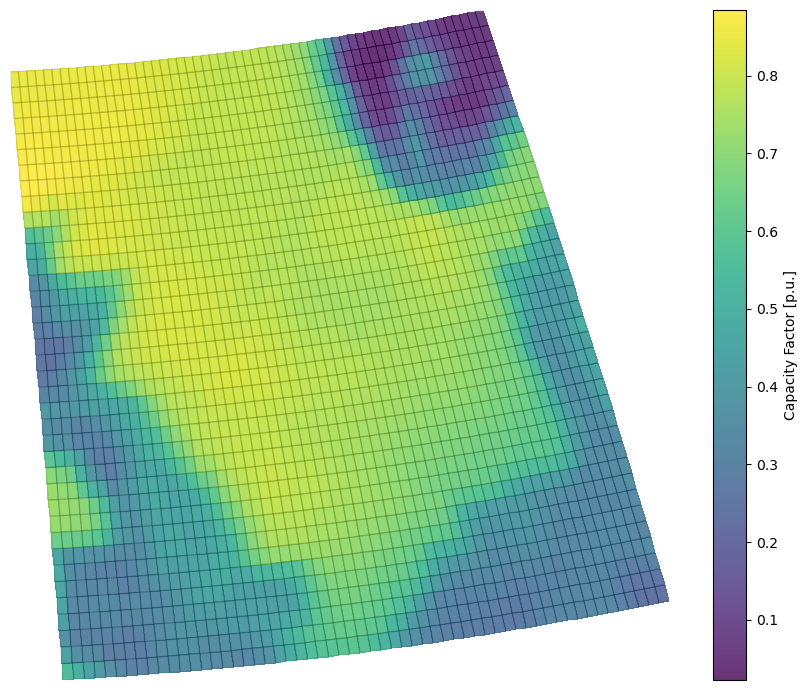

In [184]:
projection = ccrs.Orthographic(-10, 35)
cap_factors = cutout.wind(turbine='Vestas_V112_3MW', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

## Hywind Koordianten

INFO:atlite.convert:Convert and aggregate 'wind'.


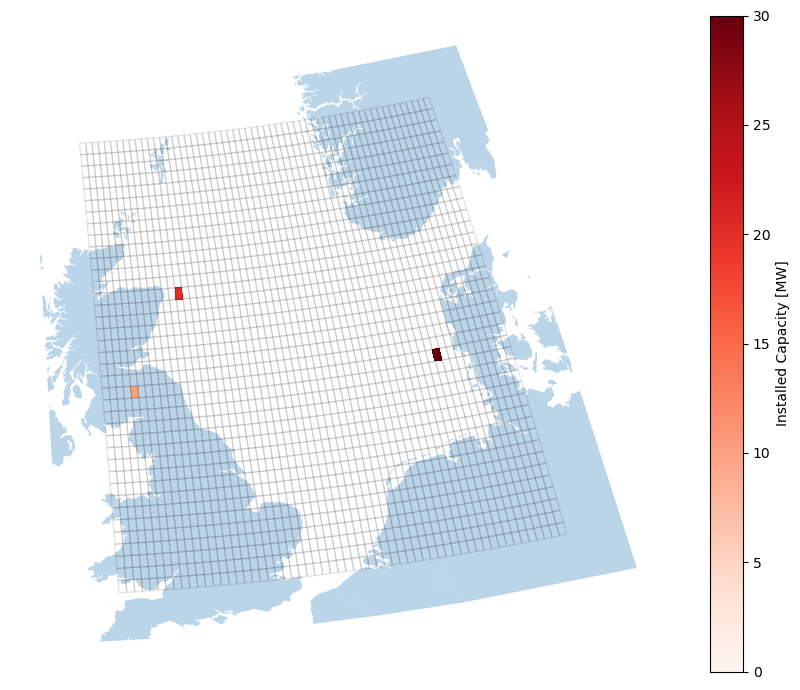

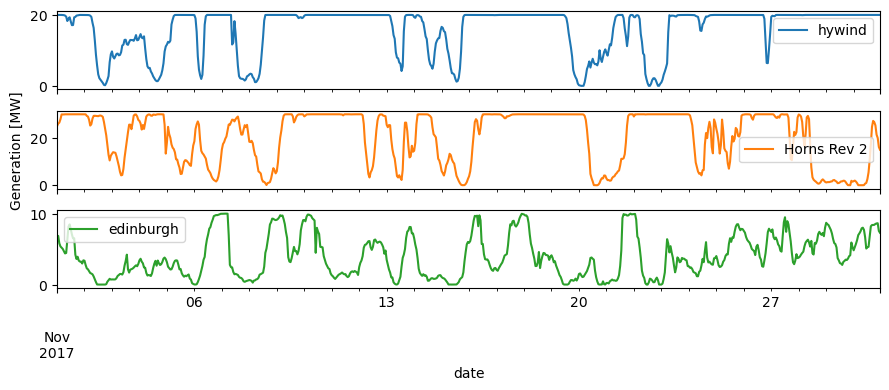

In [49]:
#57.48333°, -1.35°
# Horns Rev 2 55.6, 7.59 
sites = gpd.GeoDataFrame([['hywind', -1.35, 57.4833, 20], # erste beide Werte: Geo-Koordinaten, dritter: installierte Kapazität
                          ['Horns Rev 2', 7.59, 55.6, 30],
                          ['edinburgh', -3.13, 55.5, 10]],
                         columns=['name', 'x', 'y', 'capacity']
                         ).set_index('name')

nearest = cutout.data.sel(
    {'x': sites.x.values, 'y': sites.y.values}, 'nearest').coords
sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values
cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))

BorderingStates_init.plot(ax=ax, zorder=1, transform=plate(), alpha=0.3)
cells.plot(ax=ax, **plot_grid_dict)
layout.plot(ax=ax, transform=plate(), cmap='Reds', vmin=0,
            label='Installed Capacity [MW]')
ax.outline_patch.set_edgecolor('white')
fig.tight_layout()

fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))
power_generation = cutout.wind('Vestas_V112_3MW', layout=layout,
                               shapes=cells_generation.geometry)

power_generation.to_pandas().plot(subplots=True, ax=axes)
axes[2].set_xlabel('date')
axes[1].set_ylabel('Generation [MW]')
fig.tight_layout()

INFO:atlite.convert:Convert and aggregate 'wind'.


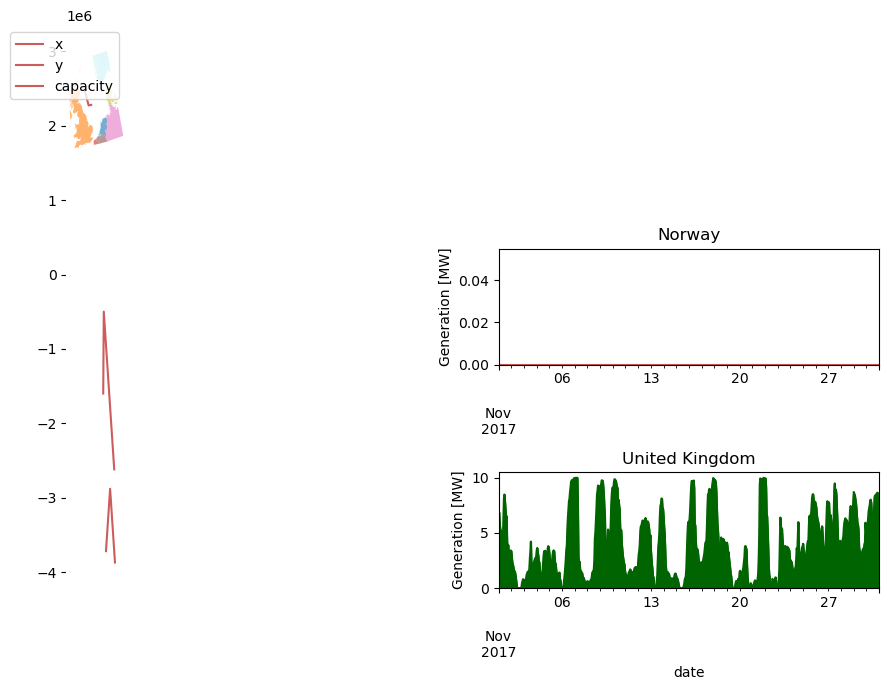

In [52]:
# im Tutorial werden Ländergrenzen importiert um erzeugungswerte zu aggregieren
from shapely.geometry import Point

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
df = gpd.GeoDataFrame(BorderingStates_init, columns=['geometry']).assign(color=['1', '2','3','4','5','6','7'])
df.plot(column='color', ax=ax, zorder=1, transform=plate(), alpha=0.6)

sites.assign(geometry=sites.apply(lambda ds: Point(ds.x, ds.y), axis=1)
             ).plot(ax=ax, zorder=2, transform=plate(), color='indianred')

ax.outline_patch.set_edgecolor('white')

power_generation = cutout.wind('Vestas_V112_3MW', layout=layout.fillna(0), shapes=BorderingStates_init
                               ).to_pandas().rename_axis(index='', columns='shapes')

ax1 = fig.add_subplot(gs[1, 2])
power_generation['Norway'].plot.area(
    ax=ax1, title='Norway', color='indianred')
ax2 = fig.add_subplot(gs[2, 2])
power_generation['United Kingdom'].plot.area(
    ax=ax2, title='United Kingdom', color='darkgreen')

ax2.set_xlabel('date')
[ax.set_ylabel('Generation [MW]') for ax in [ax1,ax2]]

fig.tight_layout()




In [ ]:
#ep = shpreader.Reader("../data/Windpark-Shapefiles GB/EMODnet_HA_WindFarms_pg_20220324.shp")

In [ ]:
windfarm_map = gpd.read_file("../data/Windpark-Shapefiles GB/EMODnet_HA_WindFarms_pg_20220324.shp")

In [ ]:
windfarm_map.iloc[271]

In [ ]:
windfarm_map.iloc[[271]].plot()

## shapefile kleiner als gridcell

In [ ]:
cutout = atlite.Cutout(path="north-sea-region-2018-small-cell-4.nc",
                       module="era5",
                       x=slice(-1.4, -2),#zu kleine Geo-werte funktionieren nicht, 0,25 ist da
                       y=slice(57.45, 58),
                       time=slice("2017-11-01","2017-11-12")
                       )

In [ ]:
cutout.prepare()

**Vorsicht Daten vom 11.11.2018 bis 12.11.2018 (Cutout hat beide Daten für 2017)**

In [ ]:
(n.iloc[1455:1503]).plot()


In [ ]:
cutout.data